In [9]:
import yfinance as yf
import pandas as pd

'''
This code cell is downloads stock market data from the previous 25 years.

It then saves the csv files locally, loads them as a pandas DataFrame, and organizes the dataframe properly.

Once the SP500 and VIX data has been cleaned and saved, a new dataframe is created that takes only the 
adjusted close valuesfrom the SP500 and VIX.

It merges the SP500 and VIX adj close data and saves it into merged_adj_closings.csv

'''

# Change window of stock market data to be analyzed
start_date = "2000-01-01"
end_date = "2025-01-01"

# Downloading data from S&P 500 and Volatility Index
sp500 = yf.download("^GSPC", start=start_date, end=end_date, auto_adjust=False)
vix = yf.download("^VIX", period="25y", auto_adjust=False)

# Save locally to data folder
sp500.to_csv("../data/sp500.csv")
vix.to_csv("../data/vix.csv")

# Load as DataFrame
sp500 = pd.read_csv("../data/sp500.csv")
vix = pd.read_csv("../data/vix.csv")

# Reorganize DataFrame
sp500 = sp500.drop(0)
sp500 = sp500.drop(1)
sp500 = sp500.rename(columns={'Price': 'Dates'})
vix = vix.drop(0)
vix = vix.drop(1)
vix = vix.rename(columns={'Price': 'Dates'})

# Save locally again
sp500.to_csv("../data/sp500.csv")
vix.to_csv("../data/vix.csv")

def print_both():
    print(sp500.head(5))
    print("")
    print(vix.head(5))
    return

# Use Adj Close as our primary data points and main focus, increased research reliability
sp500 = sp500[['Dates', 'Adj Close']]
vix = vix[['Dates', 'Adj Close']]
sp500 = sp500.rename(columns={'Adj Close': 'SP500'})
vix = vix.rename(columns={'Adj Close': 'VIX'})
data = sp500.merge(vix, how='inner')
print(data)

# Fix data types from objects to float64
data['SP500'] = pd.to_numeric(data['SP500'], errors='coerce')
data['VIX'] = pd.to_numeric(data['VIX'], errors="coerce")

# Save new merged dataframe for adj closings
data.to_csv("../data/merged_adj_closings.csv")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

           Dates               SP500                 VIX
0     2000-06-06  1457.8399658203125  23.049999237060547
1     2000-06-07  1471.3599853515625  22.479999542236328
2     2000-06-08  1461.6700439453125  22.770000457763672
3     2000-06-09   1456.949951171875  22.139999389648438
4     2000-06-12              1446.0   22.31999969482422
...          ...                 ...                 ...
6177  2024-12-24     6040.0400390625  14.270000457763672
6178  2024-12-26       6037.58984375  14.729999542236328
6179  2024-12-27       5970.83984375  15.949999809265137
6180  2024-12-30    5906.93994140625  17.399999618530273
6181  2024-12-31     5881.6298828125  17.350000381469727

[6182 rows x 3 columns]


In [10]:
import numpy as np

# Daily log return
data['log_return'] = np.log(data['SP500'] / data['SP500'].shift(1))

# Rolling volatility (20-day)
data['volatility'] = data['log_return'].rolling(window=20).std()

# 10-day momentum
data['momentum_10'] = data['SP500'] / data['SP500'].shift(10) - 1

# Simple Moving Averages (SMA)
data['sma_50'] = data['SP500'].rolling(window=50).mean()
data['sma_200'] = data['SP500'].rolling(window=200).mean()
data['sma_diff'] = data['sma_50'] - data['sma_200']

# RSI (Relative Strength Index)
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

data['14_day_rsi'] = compute_rsi(data['SP500'])

# Drop NaNs from indicators
features = data.dropna()

# Save to CSV for later use
features.to_csv("../data/features.csv")

print(data)

           Dates        SP500        VIX  log_return  volatility  momentum_10  \
0     2000-06-06  1457.839966  23.049999         NaN         NaN          NaN   
1     2000-06-07  1471.359985  22.480000    0.009231         NaN          NaN   
2     2000-06-08  1461.670044  22.770000   -0.006607         NaN          NaN   
3     2000-06-09  1456.949951  22.139999   -0.003234         NaN          NaN   
4     2000-06-12  1446.000000  22.320000   -0.007544         NaN          NaN   
...          ...          ...        ...         ...         ...          ...   
6177  2024-12-24  6040.040039  14.270000    0.010982    0.008843     0.000850   
6178  2024-12-26  6037.589844  14.730000   -0.000406    0.008756    -0.007659   
6179  2024-12-27  5970.839844  15.950000   -0.011117    0.009076    -0.013288   
6180  2024-12-30  5906.939941  17.400000   -0.010760    0.009258    -0.023822   
6181  2024-12-31  5881.629883  17.350000   -0.004294    0.009247    -0.031684   

           sma_50      sma_

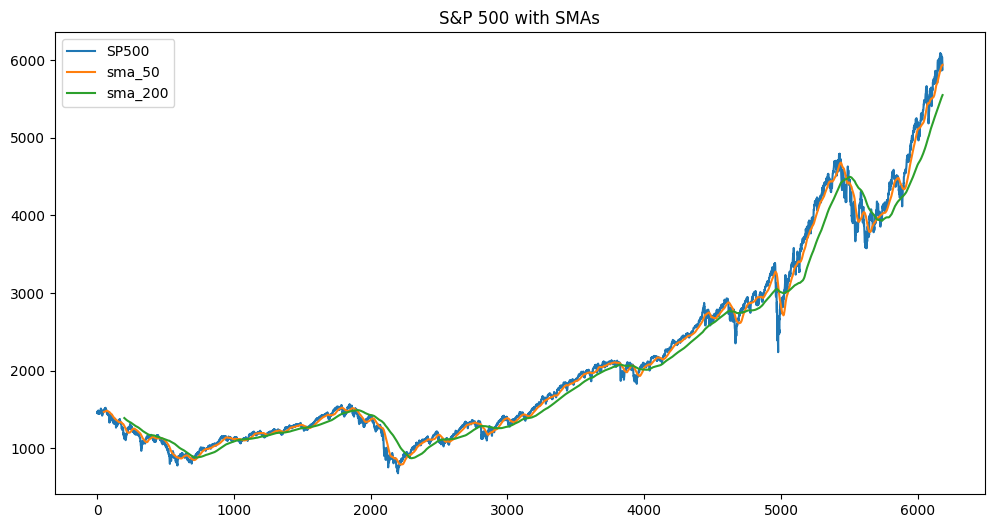

In [11]:
import matplotlib.pyplot as plt

data[['SP500', 'sma_50', 'sma_200']].plot(figsize=(12, 6), title="S&P 500 with SMAs")
plt.show()